In [3]:
# Librerias basicas test:
#Felipe
import pandas as pd
import numpy as np
import seaborn as sns
import warnings 
import os
import joblib
import xgboost as xgb
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.var_model import VAR
from itertools import product

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

sns.set_style('darkgrid')
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

Objetivo: dado alloy, area y thickness---> obtener: v,ramptime,holding time

In [4]:
df_autotreat = pd.read_csv("data_analyst.csv")
df_autotreat.head(12)

,Timestamp,Time,V,A,T,alloy,voltage,ramp_time,holding_time,area,Imax,modeling_thickness,final_thickness
0,1.687423e+09,2023-06-22 08:31:28,0.03,0.00,38.1,7075,14,30,20.0,0.5,0.53,0.0,1.204514
1,1.687423e+09,2023-06-22 08:31:29,0.03,0.00,38.1,7075,14,30,20.0,0.5,0.53,0.0,1.204514
2,1.687423e+09,2023-06-22 08:31:29,0.03,0.01,38.1,7075,14,30,20.0,0.5,0.53,0.0,1.204514
3,1.687423e+09,2023-06-22 08:31:30,0.03,0.00,38.1,7075,14,30,20.0,0.5,0.53,0.0,1.204514
4,1.687423e+09,2023-06-22 08:31:31,0.03,0.00,38.1,7075,14,30,20.0,0.5,0.53,0.0,1.204514
5,1.687423e+09,2023-06-22 08:31:32,0.03,0.01,38.1,7075,14,30,20.0,0.5,0.53,0.0,1.204514
6,1.687423e+09,2023-06-22 08:31:32,0.03,0.01,38.1,7075,14,30,20.0,0.5,0.53,0.0,1.204514
7,1.687423e+09,2023-06-22 08:31:33,0.03,0.01,38.1,7075,14,30,20.0,0.5,0.53,0.0,1.204514
8,1.687423e+09,2023-06-22 08:31:34,0.03,0.00,38.1,7075,14,30,20.0,0.5,0.53,0.0,1.204514
9,1.687423e+09,2023-06-22 08:31:35,0.03,0.01,38.1,7075,14,30,20.0,0.5,0.53,0.0,1.204514


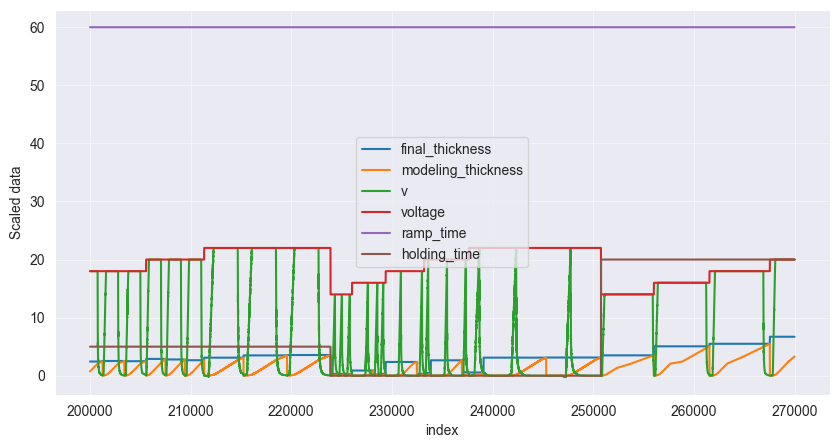

In [35]:
muesta_fin=270000
muestra_in=200000
df_autotreat['final_thickness'].iloc[muestra_in:muesta_fin].plot(figsize=(10,5))
plt.plot(df_autotreat['modeling_thickness'].iloc[muestra_in:muesta_fin],label='modeling_thickness')
plt.plot(df_autotreat['V'].iloc[muestra_in:muesta_fin],label='v')
plt.plot(df_autotreat['voltage'].iloc[muestra_in:muesta_fin],label='voltage')
plt.plot(df_autotreat['ramp_time'].iloc[muestra_in:muesta_fin],label='ramp_time')
plt.plot(df_autotreat['holding_time'].iloc[muestra_in:muesta_fin],label='holding_time')
plt.grid(alpha=0.5, which='both')
plt.xlabel('index')
plt.ylabel('Scaled data')
plt.legend()
plt.show()

Voy a predecir con el estadistico VAR

In [104]:
X = df_autotreat[['V', 'A', 'T', 'voltage', 'ramp_time', 'holding_time', 'Imax']]
y = df_autotreat[['modeling_thickness']]
df_autotreat[['V', 'A', 'T', 'voltage', 'ramp_time', 'holding_time', 'Imax','modeling_thickness']].head()

,V,A,T,voltage,ramp_time,holding_time,Imax,modeling_thickness
0,0.03,0.00,38.1,14,30,20.0,0.53,0.0
1,0.03,0.00,38.1,14,30,20.0,0.53,0.0
2,0.03,0.01,38.1,14,30,20.0,0.53,0.0
3,0.03,0.00,38.1,14,30,20.0,0.53,0.0
4,0.03,0.00,38.1,14,30,20.0,0.53,0.0


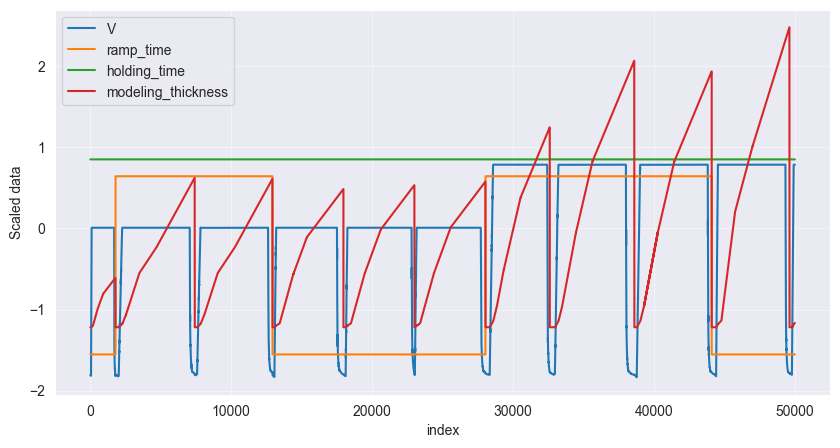

In [105]:
df_to_predict= df_autotreat[['V', 'ramp_time', 'holding_time','modeling_thickness']]
scaler = StandardScaler()

# Transform data
scaled_values = scaler.fit_transform(df_to_predict)

# Convert to dataframe
df_scaled = pd.DataFrame(scaled_values, 
                         columns=df_to_predict.columns, 
                         index=df_to_predict.index)

# Visualize data
df_scaled.iloc[:50000].plot(figsize=(10,5))
plt.grid(alpha=0.5, which='both')
plt.xlabel('index')
plt.ylabel('Scaled data')
plt.show()

In [113]:
new_df_scaled=df_scaled[['V', 'ramp_time','modeling_thickness']].iloc[:50000]
model = VAR(new_df_scaled)
optimal_lags = model.select_order()

print(f"The optimal lag order selected: {optimal_lags.selected_orders}")
#esto busca el lag mas efectivo

The optimal lag order selected: {'aic': 31, 'bic': 18, 'hqic': 20, 'fpe': 31}


In [107]:
lag_order = optimal_lags.selected_orders['bic']
results = model.fit(lag_order)

# Estimate the model (VAR) and show summary
var_model = results.model
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 09, Jan, 2024
Time:                     10:20:36
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -23.8790
Nobs:                     49982.0    HQIC:                  -23.8990
Log likelihood:           384888.    FPE:                4.13861e-11
AIC:                     -23.9081    Det(Omega_mle):     4.12497e-11
--------------------------------------------------------------------
Results for equation V
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                          0.000046         0.000034            1.365           0.172
L1.V                           0.786309         0.004470          175.919           0.000
L1.ramp_time                

In [108]:
# Forecast 
horizon = 100
forecast = results.forecast(new_df_scaled.values[-lag_order:], steps=horizon)

# Convert to dataframe
df_forecast = pd.DataFrame(forecast, 
                           columns=new_df_scaled.columns, 
                           index=df_scaled.iloc[50000:50000+horizon].index)

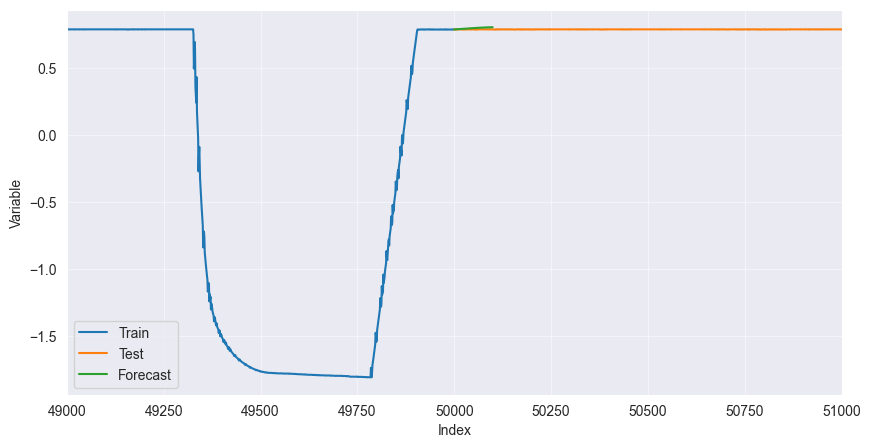

In [109]:
ax = new_df_scaled[49000:].V.plot(figsize=(10,5))
df_scaled[50000:51000+horizon].V.plot(ax=ax)
df_forecast.V.plot(ax=ax)
plt.grid(alpha=0.5, which='both')
plt.xlim(49000, 51000) 
plt.title('prediccion de V')
plt.xlabel('Index')
plt.ylabel('Variable')
plt.legend(['Train', 'Test', 'Forecast'])
plt.show()
#ramp_time
#modeling_thickness

## Prediccion Inversa

In [103]:
df_autotreat.head(5)

,Timestamp,Time,V,A,T,alloy,voltage,ramp_time,holding_time,area,Imax,modeling_thickness,final_thickness
0,1.687423e+09,2023-06-22 08:31:28,0.03,0.00,38.1,7075,14,30,20.0,0.5,0.53,0.0,1.204514
1,1.687423e+09,2023-06-22 08:31:29,0.03,0.00,38.1,7075,14,30,20.0,0.5,0.53,0.0,1.204514
2,1.687423e+09,2023-06-22 08:31:29,0.03,0.01,38.1,7075,14,30,20.0,0.5,0.53,0.0,1.204514
3,1.687423e+09,2023-06-22 08:31:30,0.03,0.00,38.1,7075,14,30,20.0,0.5,0.53,0.0,1.204514
4,1.687423e+09,2023-06-22 08:31:31,0.03,0.00,38.1,7075,14,30,20.0,0.5,0.53,0.0,1.204514


Se va a obtener del dataframe anterior los datos especificos de cada V,holndig y ramp para los espesores finales dados

In [5]:
def obtener_valores_input(data):
    '''del dataframe orignal obtener V,holndig,ramp para cada final thickness'''
    unique_final_thickness=data['final_thickness'].unique()
    final_thickness=[]
    voltg=[]
    holding=[]
    ramp=[]
    for i in unique_final_thickness:
        a=data[data['final_thickness'] == i]
        len=a.shape[0]
        #obtener los valores de los inputs a mitad de cada salto, aqui es mas fiable
        v=a['voltage'].iloc[round(len/2)]
        h=a['holding_time'].iloc[round(len/2)]
        r=a['ramp_time'].iloc[round(len/2)]
        final_thickness.append(i)
        voltg.append(v)
        holding.append(h)
        ramp.append(r)
    dict={'final_thickness':final_thickness,'Voltage':voltg,'holding_time':holding,'ramp_time':ramp}
    df = pd.DataFrame(dict)
    return df
x_input=obtener_valores_input(df_autotreat)
x_input.head()

,final_thickness,Voltage,holding_time,ramp_time
0,1.204514,14,20.0,30
1,3.659806,14,20.0,60
2,3.633425,14,20.0,60
3,3.382802,14,20.0,30
4,3.478467,14,20.0,30


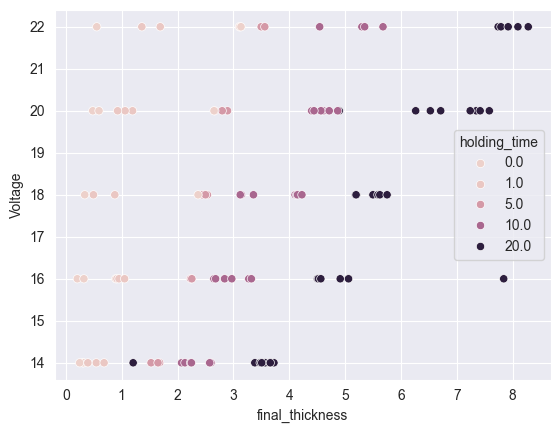

In [149]:
sns.scatterplot(x='final_thickness',y='Voltage', hue='holding_time', data=x_input)
plt.show()
#se observan ciertos outliers luego se hablara de ello

In [16]:
X = x_input[['Voltage', 'holding_time','ramp_time']] # Habrá que añadir alloy y area si en el futuro tienen variabilidad.
y = x_input[['final_thickness']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=28)

Definimos los modelos

In [52]:
models_and_params = {
        "Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "grid_params": {
            "n_estimators": [50, 100, 200, 500],
            "max_depth": [None] + list(range(10, 31, 10)),
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4]
        }
    },
    "XGBoost": {
        "model": xgb.XGBRegressor(random_state=42),
        "grid_params": {
            "n_estimators": [50, 100, 200, 500],
            "max_depth": list(range(2, 11)),
            "learning_rate": [0.01, 0.1, 0.2],
            "subsample": [0.5, 0.8, 1.0],
            "colsample_bytree": [0.5, 0.8, 1.0]
        }},
    "SVM": {
        "model": SVR(),
        "grid_params": {
            "C": [0.1, 1, 10],
            "kernel": ['linear', 'rbf', 'poly'],
            "gamma": ['scale', 'auto']
        }
    },
    "Decision Tree": {
        "model": DecisionTreeRegressor(random_state=42),
        "grid_params": {
            "max_depth": [None] + list(range(10, 31, 10)),
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4]
        }
    }
}

Obtencion de mejores parametros para los modelos

In [18]:
for model_name, model_info in models_and_params.items():
    print(f"Grid search for {model_name}...")
    
    # Configurar la búsqueda en cuadrícula
    grid = GridSearchCV(model_info["model"], 
                        model_info["grid_params"], 
                        cv=5, 
                        scoring='neg_mean_squared_error',
                        n_jobs=-1,
                        verbose=1)
    
    # Entrenar el modelo
    grid.fit(X_train, y_train)
    
    # Mejores parámetros y rendimiento
    best_params = grid.best_params_
    best_score = -grid.best_score_
    
    print(f"Best parameters: {best_params}")
    print(f"Best negative MSE: {best_score}\n")

Grid search for Random Forest...
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best negative MSE: 0.3840967285350866

Grid search for XGBoost...
Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'subsample': 0.8}
Best negative MSE: 0.3821232734855227

Grid search for SVM...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best negative MSE: 0.32441516597591674

Grid search for Decision Tree...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best negative MSE: 0.45347671911116166



Entrenamiento de los modelos

In [93]:
# Optimizar hiperparámetros para el modelo de XGBoost
xgb_grid = GridSearchCV(models_and_params["XGBoost"]["model"], 
                        models_and_params["XGBoost"]["grid_params"], 
                        cv=5, 
                        scoring='neg_mean_squared_error',
                        n_jobs=-1,
                        verbose=1)

# Entrenar el modelo
xgb_grid.fit(X_train, y_train)

# Mejores parámetros y rendimiento
best_params_xgb = xgb_grid.best_params_
best_score_xgb = -xgb_grid.best_score_

best_params_xgb, best_score_xgb

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


({'colsample_bytree': 1.0,
  'learning_rate': 0.2,
  'max_depth': 8,
  'n_estimators': 100,
  'subsample': 0.5},
 0.4809854085623971)

In [130]:
xgb_best = xgb.XGBRegressor(**{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0})
xgb_best.fit(X_train, y_train)
r2_xgb = r2_score(y_test, xgb_best.predict(X_test))
pred_vs_test = pd.DataFrame({'Test': y_test['final_thickness'].tolist(),'Pred': xgb_best.predict(X_test).tolist()})
print(pred_vs_test)
r2_xgb


        Test      Pred
0   0.247825  0.470493
1   3.134800  2.495894
2   1.204514  3.585461
3   4.146875  3.949755
4   0.552958  2.495894
5   5.201987  5.501011
6   4.609431  4.429586
7   4.130625  3.949755
8   0.893625  0.672655
9   1.525117  1.852199
10  1.193854  1.061329
11  2.255125  2.132792
12  7.344823  6.820526
13  5.620625  5.680525
14  4.911066  5.118101
15  3.121637  3.643175
16  0.876354  1.018008
17  7.787959  7.869731
18  3.496175  3.173791
19  2.131578  2.260775
20  3.561075  3.173791
21  0.307083  0.470493
22  1.678050  1.852199


0.892411491830915

In [19]:
rf_best = RandomForestRegressor(**{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}, random_state=28)
rf_best.fit(X_train, y_train)
rf_pred=rf_best.predict(X_test)
# Evaluar el rendimiento en el conjunto de prueba
r2_rf = r2_score(y_test, rf_pred)

# Mostrar resultados
pred_vs_test_rf = pd.DataFrame({'Test': y_test['final_thickness'].tolist(), 'Pred': rf_pred.tolist()})
print("Random Forest:")
print(pred_vs_test_rf)
print(f"R^2 Score: {r2_rf}\n")

# importances = rf_best.feature_importances_
# feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})

Random Forest:
        Test      Pred
0   0.247825  0.337169
1   3.134800  2.603808
2   1.204514  3.581156
3   4.146875  3.975017
4   0.552958  2.603808
5   5.201987  5.345277
6   4.609431  4.524717
7   4.130625  3.975017
8   0.893625  0.392452
9   1.525117  1.827497
10  1.193854  0.983738
11  2.255125  2.211574
12  7.344823  7.368234
13  5.620625  5.553171
14  4.911066  5.997757
15  3.121637  3.568466
16  0.876354  0.773629
17  7.787959  7.996397
18  3.496175  3.000483
19  2.131578  2.202532
20  3.561075  3.000483
21  0.307083  0.337169
22  1.678050  1.827497
R^2 Score: 0.8788922666761196



In [20]:
importances = rf_best.feature_importances_
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
print(feature_importances)

        feature  importance
0       Voltage    0.275066
1  holding_time    0.708407
2     ramp_time    0.016527


In [23]:
#Modelo SVR
svr_best = SVR(**{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'})
svr_best.fit(X_train, y_train)
svr_pred=svr_best.predict(X_test)
# Evaluar el rendimiento en el conjunto de prueba
r2_svr = r2_score(y_test, svr_pred)

# Mostrar resultados
pred_vs_test_svr = pd.DataFrame({'Test': y_test['final_thickness'].tolist(), 'Pred': svr_pred.tolist()})
print("Random Forest:")
print(pred_vs_test_svr)
print(f"R^2 Score: {r2_svr}\n")

Random Forest:
        Test      Pred
0   0.247825  0.309953
1   3.134800  1.295033
2   1.204514  3.578357
3   4.146875  4.125440
4   0.552958  1.295033
5   5.201987  5.380619
6   4.609431  4.485648
7   4.130625  4.125440
8   0.893625  0.472982
9   1.525117  1.549134
10  1.193854  1.027290
11  2.255125  2.122905
12  7.344823  7.316173
13  5.620625  5.792797
14  4.911066  4.959534
15  3.121637  3.501985
16  0.876354  0.885211
17  7.787959  7.992088
18  3.496175  3.206804
19  2.131578  2.146680
20  3.561075  3.206804
21  0.307083  0.309953
22  1.678050  1.549134
R^2 Score: 0.9014249090808506



Realizacion de la prediccion inversa, para ello se hace un mallado de V,holding,ramp y luego con el modelo deseado se hacen un conjunto de predicciones del espesor.
Con esas predicciones se observa cual es la que mejor se ajusta a la real y se toman los valores de V,holding,ramp de esa como los correctos

In [132]:
#Prediccion inversa
#primera prueba
V_test=X['Voltage'].unique().tolist()
Holding_test=[20., 10.,  5.,  0.,  1.]
Ramp_test=[30,60]
combinaciones = np.array(list(product(V_test, Holding_test,Ramp_test)))#mallado de todas las combinaciones posibles
comb_scalated=scaler.transform(combinaciones)
#esto para a partir de un espesor con pocos decimales sacar el verdadero del dataframe
test_thickness=0.307083
test_espesor_=x_input[(x_input['final_thickness']>test_thickness-0.0005) & (x_input['final_thickness']<test_thickness+0.0005)]
print(test_espesor_['final_thickness'].iloc[0])

0.307083333333333


In [133]:
pred=rf_best.predict(comb_scalated)

In [134]:
diferencias_absolutas = np.abs(pred - test_thickness)

#índice del valor mínimo
indice_valor_minimo = np.argmin(diferencias_absolutas)
valor_mas_cercano = pred[indice_valor_minimo]

print('El valor mas cercano es: ',valor_mas_cercano,'El valor esperado es: ',test_thickness)
inputs = scaler.inverse_transform([comb_scalated[indice_valor_minimo]])
print('Los inputs calculados son: ',inputs)
print('Los inputs reales son: ')
#x_input[x_input['final_thickness']==1.2045138888888722]
test_espesor_


El valor mas cercano es:  0.30788739583333324 El valor esperado es:  0.307083
Los inputs calculados son:  [[14.  0. 30.]]
Los inputs reales son: 


,final_thickness,Voltage,holding_time,ramp_time
50,0.307083,14,0.0,60


In [135]:
#lo mismo pero solo con los valores que hemos usado en el modelo
X.values
new_pred=rf_best.predict(X_scaled)
new_diferencias_absolutas = np.abs(new_pred - test_thickness)

#índice del valor mínimo
new_indice_valor_minimo = np.argmin(new_diferencias_absolutas)
new_valor_mas_cercano = new_pred[new_indice_valor_minimo]
print('El valor mas cercano es: ',new_valor_mas_cercano,'El valor esperado es: ',test_thickness)
inputs = X.values[new_indice_valor_minimo,]#scaler.inverse_transform([X_scaled[indice_valor_minimo]])
print('Los inputs calculados son: ',inputs)
print('Los inputs reales son: ')
#x_input[x_input['final_thickness']==1.2045138888888722]
test_espesor_

El valor mas cercano es:  0.30788739583333324 El valor esperado es:  0.307083
Los inputs calculados son:  [14.  0. 60.]
Los inputs reales son: 


,final_thickness,Voltage,holding_time,ramp_time
50,0.307083,14,0.0,60


Ahora vamos a comparar los resultados de y_test: valor real, el predicho por estas predicciones inversas (pred) y lo mismo teniendo solo en cuenta 
los valores del modelo (new_pred)

In [136]:
pred_thickness=[]
new_pred_thickness=[]
inputs=np.array([])
new_inputs=np.array([])
for i in y_test['final_thickness']:
    #predicciones con mallado
    diferencias_absolutas = np.abs(pred - i)
    indice_valor_minimo = np.argmin(diferencias_absolutas)
    valor_mas_cercano = pred[indice_valor_minimo]
    pred_thickness.append(valor_mas_cercano)
    #predicciones solo con las del modelo
    new_diferencias_absolutas = np.abs(new_pred - i)
    new_indice_valor_minimo = np.argmin(new_diferencias_absolutas)
    new_valor_mas_cercano = new_pred[new_indice_valor_minimo]
    new_pred_thickness.append(new_valor_mas_cercano)
    if inputs.size == 0:
        inputs = comb_scalated[indice_valor_minimo]
    else:
        inputs = np.vstack((inputs, comb_scalated[indice_valor_minimo]))
    if new_inputs.size == 0:
        new_inputs = X.values[new_indice_valor_minimo,]
    else:
        new_inputs = np.vstack((new_inputs, X.values[new_indice_valor_minimo,]))
    
    
inputs_rescaled = scaler.inverse_transform(inputs)
pred_V=inputs_rescaled[:,0]
pred_H=inputs_rescaled[:,1]
pred_R=inputs_rescaled[:,2]

new_pred_V=new_inputs[:,0]
new_pred_H=new_inputs[:,1]
new_pred_R=new_inputs[:,2]

"\nprint('El valor mas cercano es: ',valor_mas_cercano,'El valor esperado es: ',test_thickness)\ninputs = scaler.inverse_transform([comb_scalated[indice_valor_minimo]])"

In [138]:
inverse_pred=pd.DataFrame({'Pred_Thickness':pred_thickness,'Pred_V':pred_V,'Pred_H':pred_H,'Pred_R':pred_R})
inverse_new_pred=pd.DataFrame({'New_Pred_Thickness':new_pred_thickness,'New_Pred_V':new_pred_V,'New_Pred_H':new_pred_H
                               ,'New_Pred_R':new_pred_R})
real_inputs=scaler.inverse_transform(X_test[:])
inverse_REAL=pd.DataFrame({'Real_Thickness':y_test['final_thickness'],'Real_V':real_inputs[:,0],'Real_Holding':real_inputs[:,1]
                                       ,'Real_Ramp':real_inputs[:,2]}).reset_index(drop=True)
inverse_comparacion = pd.concat([inverse_REAL, inverse_pred,inverse_new_pred], axis=1)
inverse_comparacion.head()

,Real_Thickness,Real_V,Real_Holding,Real_Ramp,Pred_Thickness,Pred_V,Pred_H,Pred_R,New_Pred_Thickness,New_Pred_V,New_Pred_H,New_Pred_R
0,0.247825,14.0,0.0,60.0,0.307887,14.0,0.0,30.0,0.307887,14.0,0.0,60.0
1,3.134800,22.0,0.0,60.0,3.129357,18.0,10.0,30.0,3.129357,18.0,10.0,30.0
2,1.204514,14.0,20.0,30.0,1.180527,18.0,0.0,30.0,1.180527,18.0,0.0,60.0
3,4.146875,18.0,10.0,30.0,4.460741,20.0,10.0,60.0,4.460741,20.0,10.0,60.0
4,0.552958,22.0,0.0,60.0,0.532447,16.0,0.0,30.0,0.532447,16.0,0.0,60.0


El valor:       
1	3.134800	-22.0-	0.0-	60.0-	3.129357-	18.0-	10.0-	30.0-	3.129357-	18.0-	10.0-	30.0 -       
Es erroneo ya que 22.0	0.0	60.0 es un valor anomalo dentro del holding=0.
Además el valor:        
2	1.204514-	14.0-	20.0-	30.0-	1.180527-	18.0-	0.0-	30.0-	1.180527-	18.0-	0.0-	60.0-
Es outlier tanto 1.204514-	14.0-	20.0-	30.0- como 18.0-	0.0-	30.0-

Se ve por tanto que la prediccion inversa tiene ciertos fallos debido a la presencia de outliers que hace que el modelo sobreentrene estos outliers asignandolo a valores no deseados

In [98]:
print(x_input[(x_input['Voltage']==14.0) & (x_input['holding_time']==20.0)& (x_input['ramp_time']==30.0)])
'''
df_autotreat['voltage'].unique()
print(x_input[(x_input['Voltage']==18.00) & (x_input['holding_time']==10.0)].final_thickness.iloc[0])
x_input['final_thickness'].iloc[51]
df_autotreat[df_autotreat['final_thickness']==4.103187499999577]'''

    final_thickness  Voltage  holding_time  ramp_time
0          1.204514       14          20.0         30
3          3.382802       14          20.0         30
4          3.478467       14          20.0         30
5          3.566691       14          20.0         30
90         3.664941       14          20.0         30
91         3.724983       14          20.0         30
92         3.659483       14          20.0         30


"\ndf_autotreat['voltage'].unique()\nprint(x_input[(x_input['Voltage']==18.00) & (x_input['holding_time']==10.0)].final_thickness.iloc[0])\nx_input['final_thickness'].iloc[51]\ndf_autotreat[df_autotreat['final_thickness']==4.103187499999577]"

In [18]:
#print(x_input[(x_input['Voltage']==20.00) & (x_input['holding_time']==20.0)])
print(x_input[(x_input['Voltage']==18.00) & (x_input['holding_time']==10.0) & (x_input['ramp_time']==30.0)])
print(x_input[(x_input['Voltage']==22.00) & (x_input['holding_time']==0.0) & (x_input['ramp_time']==60.0)])
print(x_input[(x_input['Voltage']==22.0) ].sort_values(by=['holding_time'], ascending=False))
#x_input.groupby('holding_time').head(5)

     final_thickness  Voltage  holding_time  ramp_time
105         4.130625       18          10.0         30
106         4.146875       18          10.0         30
107         4.225625       18          10.0         30
    final_thickness  Voltage  holding_time  ramp_time
61         0.552958       22           0.0         60
62         3.112675       22           0.0         60
63         3.134800       22           0.0         60
    final_thickness  Voltage  holding_time  ramp_time
17         7.738084       22          20.0         60
18         7.787959       22          20.0         60
68         8.276734       22          20.0         60
87         7.917634       22          20.0         60
19         8.092197       22          20.0         60
33         5.349072       22          10.0         60
34         5.677000       22          10.0         60
32         5.299197       22          10.0         60
73         4.543591       22          10.0         60
47         3.106775     

In [14]:
limited_df_autotreat=df_autotreat[(df_autotreat['holding_time']==0.0)]
limited_df_autotreat.head()
len=limited_df_autotreat.shape[0]
print(len)

26871


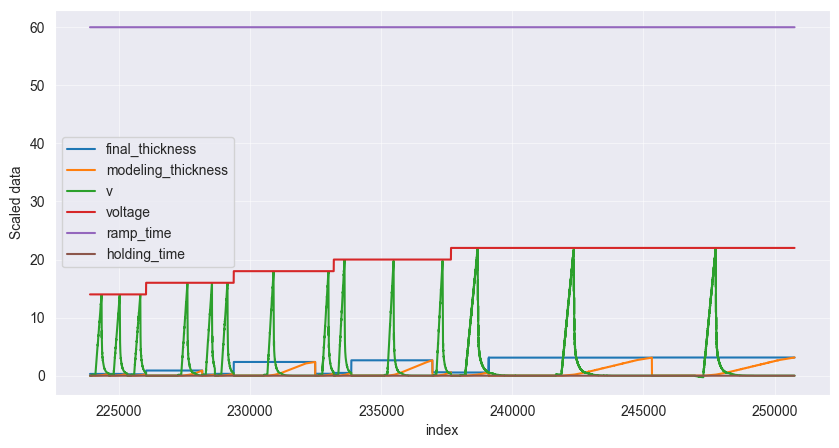

In [15]:
muesta_fin=len
muestra_in=0
limited_df_autotreat['final_thickness'].iloc[muestra_in:muesta_fin].plot(figsize=(10,5))
plt.plot(limited_df_autotreat['modeling_thickness'].iloc[muestra_in:muesta_fin],label='modeling_thickness')
plt.plot(limited_df_autotreat['V'].iloc[muestra_in:muesta_fin],label='v')
plt.plot(limited_df_autotreat['voltage'].iloc[muestra_in:muesta_fin],label='voltage')
plt.plot(limited_df_autotreat['ramp_time'].iloc[muestra_in:muesta_fin],label='ramp_time')
plt.plot(limited_df_autotreat['holding_time'].iloc[muestra_in:muesta_fin],label='holding_time')
plt.grid(alpha=0.5, which='both')
plt.xlabel('index')
plt.ylabel('Scaled data')
plt.legend()
plt.show()

## Vamos a quitar los valores anomalos (holding =0)

Se ha observado que en Holding=0 hay diversos valores anomalos o outliers, lo que daba lugar en momentos a predicciones erroneas,se van a quitar a ver si el modelo mejora un poco. Por otro lado, es cierto que hay outliers para otros holding, pero debido a que son pocos en relacion a holding=0 y que tenemos pocos datos se van a dejar. Se podría plantear eliminarlos tambien.

In [51]:
'''valores anomalos en holding=0:
    22:62,63
    20:59
    18;56
    16:53- no por mucho (duda)

'''
#para holding=0 lo normal son valores bajos ~0.2-0.5 por ello se filtra por final_thickness>0.8
print(x_input[(x_input['holding_time']==0.0) & (x_input['final_thickness']>0.8) ].sort_values(by=['Voltage'], ascending=False))

---Voltage =  20.0 ---
     final_thickness  Voltage  holding_time  ramp_time
62         3.112675       22           0.0         60
63         3.134800       22           0.0         60
59         2.652308       20           0.0         60
56         2.366600       18           0.0         60
53         0.893625       16           0.0         60


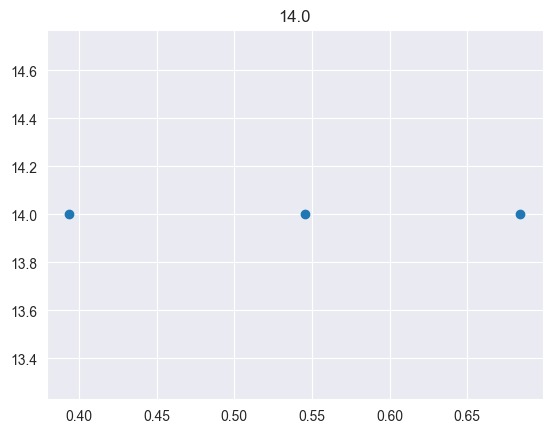

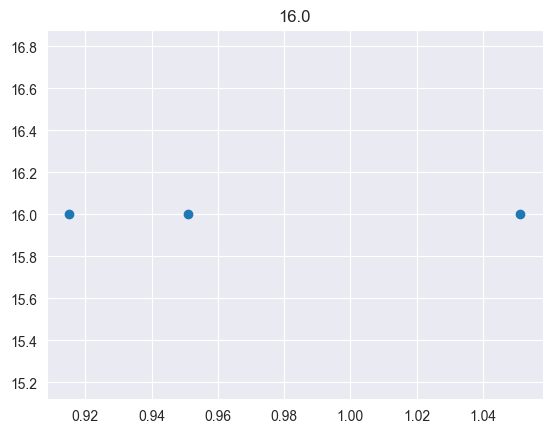

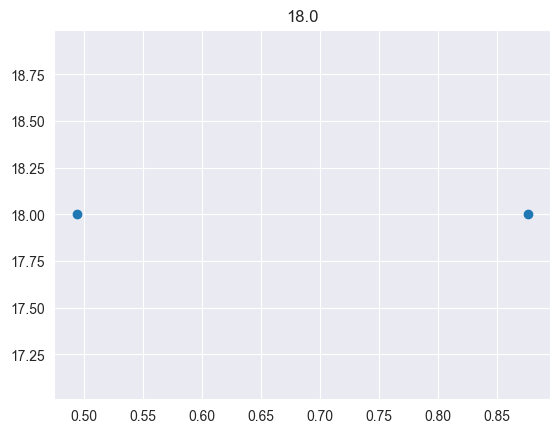

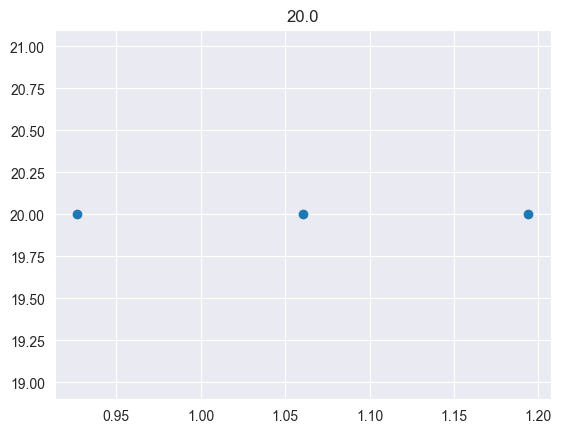

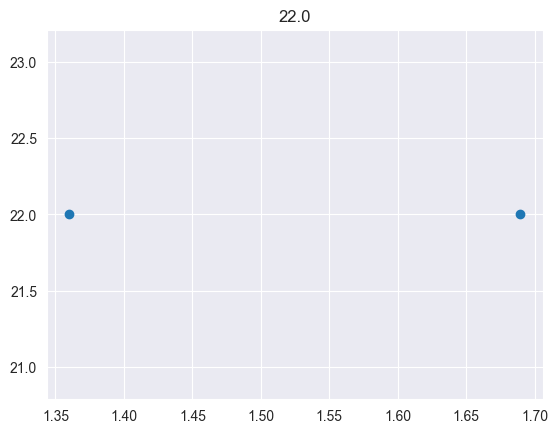

'outlier:\n    holding 20:14,16,20\n    10:22(duda)\n\n    '

In [109]:
#aqui he buscado outliers en otros holding  -  IGNORAR por ahora
for i in [14.0,16.0,18.0,20.0,22.0]:    
    show=x_input[(x_input['Voltage']==i) & (x_input['holding_time']==1.0)]
    plt.scatter(show['final_thickness'],show[['Voltage']])
    plt.title(i)
    plt.show()
'''outlier:
    holding 20:14,16,20
    10:22(duda)
    '''

Se podría estudiar más adelante quitar estos outliers. Vamos a quitar los outliers en holding =0.

In [50]:
x_input_outlier_filter=x_input.drop(x_input[(x_input['holding_time']==0.0) & (x_input['final_thickness']>0.8) ].index)
x_input_outlier_filter[(x_input_outlier_filter['holding_time']==0.0)  ]

,final_thickness,Voltage,holding_time,ramp_time
50,0.307083,14,0.0,60
51,0.311417,14,0.0,60
52,0.247825,14,0.0,60
54,0.205250,16,0.0,60
55,0.322583,16,0.0,60
57,0.338125,18,0.0,60
58,0.481854,20,0.0,60
60,0.593104,20,0.0,60
61,0.552958,22,0.0,60


In [56]:
X_out = x_input_outlier_filter[['Voltage', 'holding_time','ramp_time']]
y_out = x_input_outlier_filter[['final_thickness']]

scaler_outlier = StandardScaler()
X_scaled_outlier = scaler_outlier.fit_transform(X_out)
X_train, X_test, y_train, y_test = train_test_split(X_scaled_outlier, y_out, test_size=0.2, random_state=28)

Busqueda de hiperpàrametros

In [57]:
for model_name, model_info in models_and_params.items():
    print(f"Grid search for {model_name}...")
    
    # Configurar la búsqueda en cuadrícula
    grid = GridSearchCV(model_info["model"], 
                        model_info["grid_params"], 
                        cv=5, 
                        scoring='neg_mean_squared_error',
                        n_jobs=-1,
                        verbose=1)
    
    # Entrenar el modelo
    grid.fit(X_train, y_train)
    
    # Mejores parámetros y rendimiento
    best_params = grid.best_params_
    best_score = -grid.best_score_
    
    print(f"Best parameters: {best_params}")
    print(f"Best negative MSE: {best_score}\n")

Grid search for Random Forest...
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best negative MSE: 0.15380003695888228

Grid search for XGBoost...
Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 1.0}
Best negative MSE: 0.10386856615547795

Grid search for SVM...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best negative MSE: 0.1123527077071252

Grid search for Decision Tree...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best negative MSE: 0.14413686056226332



In [58]:
#Modelo SVR
svr_best = SVR(**{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'})
svr_best.fit(X_train, y_train)
svr_pred=svr_best.predict(X_test)
# Evaluar el rendimiento en el conjunto de prueba
r2_svr = r2_score(y_test, svr_pred)

# Mostrar resultados
pred_vs_test_svr = pd.DataFrame({'Test': y_test['final_thickness'].tolist(), 'Pred': svr_pred.tolist()})
print("SVR:")
print(pred_vs_test_svr)
print(f"R^2 Score: {r2_svr}\n")

SVR:
        Test      Pred
0   1.204514  3.564994
1   2.131578  2.161633
2   5.620625  5.799767
3   0.322583  0.468995
4   4.609431  4.465936
5   5.201987  5.294826
6   7.416156  7.337444
7   3.496175  3.260383
8   4.911066  4.801657
9   7.344823  7.337444
10  7.917634  7.992197
11  1.525117  1.578447
12  2.255125  2.132792
13  4.130625  4.125344
14  4.146875  4.125344
15  0.950958  0.846308
16  7.787959  7.992197
17  3.724983  3.564994
18  0.915125  0.846308
19  5.349072  5.399519
20  7.837834  4.801657
21  1.360167  1.551632
R^2 Score: 0.8876221794595928



In [67]:
rf_best = RandomForestRegressor(**{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}, random_state=28)
rf_best.fit(X_train, y_train)
rf_pred=rf_best.predict(X_test)
# Evaluar el rendimiento en el conjunto de prueba
r2_rf = r2_score(y_test, rf_pred)

# Mostrar resultados
pred_vs_test_rf = pd.DataFrame({'Test': y_test['final_thickness'].tolist(), 'Pred': rf_pred.tolist(), 'Err':(100*(y_test['final_thickness']-rf_pred)/y_test['final_thickness']).tolist()})
print("Random Forest:")
print(pred_vs_test_rf)
print(f"R^2 Score: {r2_rf}\n")

Random Forest:
        Test      Pred         Err
0   1.204514  3.555502 -195.181479
1   2.131578  2.214546   -3.892332
2   5.620625  5.559935    1.079778
3   0.322583  0.269253   16.532288
4   4.609431  4.538753    1.533350
5   5.201987  5.324455   -2.354253
6   7.416156  7.164539    3.392825
7   3.496175  3.250756    7.019645
8   4.911066  5.003940   -1.891129
9   7.344823  7.164539    2.454570
10  7.917634  7.961512   -0.554180
11  1.525117  1.735568  -13.799047
12  2.255125  2.260554   -0.240724
13  4.130625  3.933474    4.772902
14  4.146875  3.933474    5.146060
15  0.950958  0.923710    2.865349
16  7.787959  7.961512   -2.228478
17  3.724983  3.555502    4.549839
18  0.915125  0.923710   -0.938129
19  5.349072  5.177694    3.203877
20  7.837834  5.003940   36.156596
21  1.360167  1.507648  -10.842917
R^2 Score: 0.8957833676652824



Tanto el 1.204514 como el 7.837834 son outliers, por lo que predice bien el modelo

In [69]:
scaler_outlier.inverse_transform([X_test[20]])
print(x_input_outlier_filter[(x_input_outlier_filter['Voltage']==16.0) & (x_input_outlier_filter['holding_time']==20.0)].sort_values(by=['ramp_time'], ascending=False))

    final_thickness  Voltage  holding_time  ramp_time
12         5.063653       16          20.0         60
13         4.911066       16          20.0         60
65         5.059741       16          20.0         60
86         7.837834       16          20.0         60
93         4.503566       16          20.0         30
94         4.520344       16          20.0         30
95         4.564385       16          20.0         30


Preddiccion inversa

In [74]:
#Prediccion inversa
V_test=X_out['Voltage'].unique().tolist()
Holding_test=[20., 10.,  5.,  0.,  1.]
Ramp_test=[30,60]
combinaciones = np.array(list(product(V_test, Holding_test,Ramp_test)))#mallado de todas las combinaciones posibles
comb_scalated=scaler_outlier.transform(combinaciones)
#esto para a partir de un espesor con pocos decimales sacar el verdadero del dataframe
test_thickness=7.787959
test_espesor_=x_input_outlier_filter[(x_input_outlier_filter['final_thickness']>test_thickness-0.0005) & (x_input_outlier_filter['final_thickness']<test_thickness+0.0005)]
print(test_espesor_['final_thickness'].iloc[0])
print(V_test)

7.787959374999188
[14, 20, 16, 18, 22]


In [75]:
pred=rf_best.predict(comb_scalated)

In [76]:
diferencias_absolutas = np.abs(pred - test_thickness)

#índice del valor mínimo
indice_valor_minimo = np.argmin(diferencias_absolutas)
valor_mas_cercano = pred[indice_valor_minimo]

print('El valor mas cercano es: ',valor_mas_cercano,'El valor esperado es: ',test_thickness)
inputs = scaler_outlier.inverse_transform([comb_scalated[indice_valor_minimo]])
print('Los inputs calculados son: ',inputs)
print('Los inputs reales son: ')
#x_input[x_input['final_thickness']==1.2045138888888722]
test_espesor_

El valor mas cercano es:  7.961512321130098 El valor esperado es:  7.787959
Los inputs calculados son:  [[22. 20. 60.]]
Los inputs reales son: 


,final_thickness,Voltage,holding_time,ramp_time
18,7.787959,22,20.0,60


Ahora vamos a comparar los resultados de y_test: valor real, el predicho por estas predicciones inversas (pred) y lo mismo teniendo solo en cuenta 
los valores del modelo (new_pred)

In [79]:
pred_thickness=[]
new_pred_thickness=[]
inputs=np.array([])
new_inputs=np.array([])
for i in y_test['final_thickness']:
    #predicciones con mallado
    diferencias_absolutas = np.abs(pred - i)
    indice_valor_minimo = np.argmin(diferencias_absolutas)
    valor_mas_cercano = pred[indice_valor_minimo]
    pred_thickness.append(valor_mas_cercano)
    #predicciones solo con las del modelo
    '''
    new_diferencias_absolutas = np.abs(new_pred - i)
    new_indice_valor_minimo = np.argmin(new_diferencias_absolutas)
    new_valor_mas_cercano = new_pred[new_indice_valor_minimo]
    new_pred_thickness.append(new_valor_mas_cercano)'''
    if inputs.size == 0:
        inputs = comb_scalated[indice_valor_minimo]
    else:
        inputs = np.vstack((inputs, comb_scalated[indice_valor_minimo]))
    '''
    if new_inputs.size == 0:
        new_inputs = x_input_outlier_filter.values[new_indice_valor_minimo,]
    else:
        new_inputs = np.vstack((new_inputs, x_input_outlier_filter.values[new_indice_valor_minimo,]))'''
    
    
inputs_rescaled = scaler_outlier.inverse_transform(inputs)
pred_V=inputs_rescaled[:,0]
pred_H=inputs_rescaled[:,1]
pred_R=inputs_rescaled[:,2]
'''
new_pred_V=new_inputs[:,0]
new_pred_H=new_inputs[:,1]
new_pred_R=new_inputs[:,2]'''

'\nnew_pred_V=new_inputs[:,0]\nnew_pred_H=new_inputs[:,1]\nnew_pred_R=new_inputs[:,2]'

In [133]:
def find_real_thickness_from_inputs(dataV,dataH,dataR):
    real_T=np.array([])
    len=dataV.shape[0]
    for i in range(0,len):
        try:
            real_T=np.append(real_T,np.round(x_input_outlier_filter[(x_input_outlier_filter['Voltage']==dataV[i]) 
                                                                    & (x_input_outlier_filter['holding_time']==dataH[i])
                                                                    & (x_input_outlier_filter['ramp_time']==dataR[i])].final_thickness.iloc[0],6))
        except:
            real_T=np.append(real_T,'Nan')
    
    return real_T
real_thickness_=find_real_thickness_from_inputs(pred_V,pred_H,pred_R)
de_real_thickness_=pd.DataFrame({'real_thickness_pred':real_thickness_})

Seguido de esto obtenemos un dataframe donde se tienen los datos reales (Real_Thickness),  los predichos (Pred_Thickness) y los espesores Reales  relacionados con los inputs predichos(real_thickness_pred), es decir, con los inputs predichos obtener el espesor real correspondiente. Debido a esto, es posible que haya inputs que no tienen ningun  espesor real asociado (Nan) ya que hemos generado más inputs en el mallado que los que teneiamos en el dataframe original.

In [134]:
inverse_pred=pd.DataFrame({'Pred_Thickness':pred_thickness,'Pred_V':pred_V,'Pred_H':pred_H,'Pred_R':pred_R})
real_inputs=scaler_outlier.inverse_transform(X_test[:])
inverse_REAL=pd.DataFrame({'Real_Thickness':y_test['final_thickness'],'Real_V':real_inputs[:,0],'Real_Holding':real_inputs[:,1]
                                       ,'Real_Ramp':real_inputs[:,2]}).reset_index(drop=True)
inverse_comparacion = pd.concat([inverse_REAL, inverse_pred,de_real_thickness_], axis=1)#,inverse_new_pred
inverse_comparacion.head(10)

,Real_Thickness,Real_V,Real_Holding,Real_Ramp,Pred_Thickness,Pred_V,Pred_H,Pred_R,real_thickness_pred
0,1.204514,14.0,20.0,30.0,1.045086,20.0,1.0,30.0,Nan
1,2.131578,14.0,10.0,60.0,2.214546,14.0,10.0,60.0,2.071278
2,5.620625,18.0,20.0,30.0,5.559935,18.0,20.0,30.0,5.585625
3,0.322583,16.0,0.0,60.0,0.340236,18.0,0.0,30.0,Nan
4,4.609431,20.0,10.0,60.0,4.659193,20.0,10.0,30.0,4.86599
5,5.201987,18.0,20.0,60.0,5.177694,22.0,10.0,60.0,5.299197
6,7.416156,20.0,20.0,30.0,7.164539,20.0,20.0,30.0,7.344823
7,3.496175,22.0,5.0,60.0,3.555502,14.0,20.0,30.0,1.204514
8,4.911066,16.0,20.0,60.0,5.003940,16.0,20.0,60.0,5.063653
9,7.344823,20.0,20.0,30.0,7.164539,20.0,20.0,30.0,7.344823


Vemos que comparando con los resultados reales hay resultados muy similares aunque los inputs no sean los mismos
con distinto input se pueden obtener espesores finales muy similares

In [93]:
print(x_input_outlier_filter[(x_input_outlier_filter['Voltage']==20.0) & (x_input_outlier_filter['holding_time']==1.0)& (x_input_outlier_filter['ramp_time']==60.0)])
#vemos que comparando con los resultados reales (en vez de ramp 30 ponemos 60 porque no hay valores de 30) hay resultados muy similares aunque los inputs no sean los mismos
#con distinto input se pueden obtener espesores finales muy similares

    final_thickness  Voltage  holding_time  ramp_time
81         1.193854       20           1.0         60
82         1.060354       20           1.0         60
83         0.926854       20           1.0         60
